In [2]:
import multiprocessing
multiprocessing.set_start_method('fork')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

!pip3 install transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# import warnings
# warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
EPOCHS=10
MAX_LEN=216
BATCH_SIZE=32

cpu


In [5]:
# Collect Data: Gather a dataset of emails labeled as phishing or non-phishing. 
# Public datasets like the Enron email dataset can be used, or you may collect data internally.

df = pd.read_csv('Phishing_Email.csv')[['Email Text', 'Email Type']]

df['Email Type'] = df['Email Type'].str.strip().str.lower().apply(lambda x: 1 if x == 'phishing email' else 0)
df.head(5)


,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


In [6]:
df.shape

(18650, 2)

In [7]:
class PhishingCollection(Dataset):
    def __init__(self, phishing, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.phishing = phishing
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        phishing = self.phishing[i]

        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            padding='max_length',  # Use padding='max_length' instead of pad_to_max_length=True
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'phishing': torch.tensor(phishing, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = PhishingCollection(
        phishing=df['Email Type'].to_numpy(),
        msgs=df['Email Text'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

In [8]:

df_train, df_test = tts(
    df,
    test_size=0.2,
    random_state=42
)
df_val, df_test = tts(
    df_test,
    test_size=0.5,
    random_state=42
)
df_train.shape, df_test.shape, df_val.shape

# Reduce dataset size by sampling a fraction of each set
sample_fraction = 0.1  # Use 10% of each dataset for faster testing

# Sample a subset of each dataset
df_train = df_train.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
df_val = df_val.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Check the new shapes
df_train.shape, df_test.shape, df_val.shape


((1492, 2), (186, 2), (186, 2))

In [9]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
     

In [10]:
d = next(iter(train_data_loader))
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'phishing'])

In [11]:
class PhishingClassifier(nn.Module):
    def __init__(self, n_classes):
        super(PhishingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [12]:
model = PhishingClassifier(n_classes=2)
model = model.to(device)

In [13]:

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/Users/kevin/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:

def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['phishing'].to(device)

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)
    
    return train_acc, train_loss

In [15]:

def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples   
):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['phishing'].to(device)

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss

In [ ]:
from tqdm import tqdm
from collections import defaultdict

# Initialize the history dictionary and best accuracy
history = defaultdict(list)
best_accuracy = 0

# Load best model for retraining
# model.load_state_dict(torch.load('best_model_state.bin'))

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # Wrap the training function in a progress bar
    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        tqdm(train_data_loader, desc="Training", leave=False),  # Adds tqdm progress bar
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = evaluate_model(
        model,
        loss_fn,
        device,
        tqdm(val_data_loader, desc="Validation", leave=False),  # Adds tqdm progress bar
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


In [24]:

model.load_state_dict(torch.load('/Users/kevin/Desktop/NLP_IW/bert/best_model_state.bin', map_location=torch.device('cpu')))

test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

/var/folders/wv/9lrvdvw14l3f9j39qf4g1syc0000gn/T/ipykernel_83792/1455312217.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/kevi

0.9731182795698925

In [25]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            phishing = d['phishing'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(phishing)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

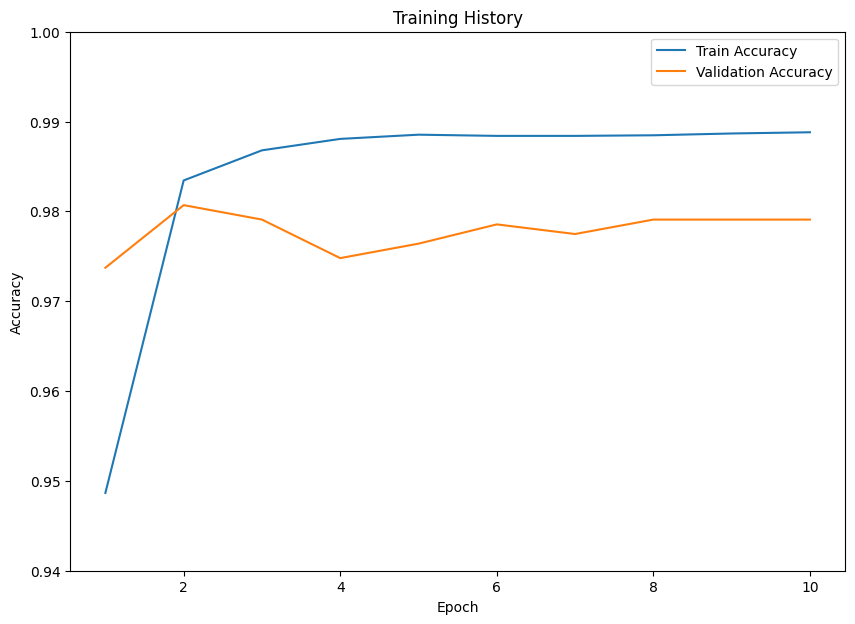

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from 'history.csv'
history_df = pd.DataFrame({
    "epoch": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "train_loss": [0.15226489138135155, 0.0456310126156619, 0.031596916578406645, 0.026808589044297823, 
                   0.024118705419379015, 0.02485311183163903, 0.02266470261119873, 0.022219944533446962, 
                   0.021538315704664225, 0.021363896422369473],
    "train_acc": [0.9486595174262735, 0.9834450402144773, 0.9867962466487936, 0.9880697050938338, 
                  0.9885388739946381, 0.9884048257372655, 0.9884048257372655, 0.9884718498659518, 
                  0.9886729222520109, 0.9888069705093835],
    "val_loss": [0.07489941875464243, 0.07761902102163762, 0.09760617625285634, 0.13534392727246103, 
                 0.12905614293405462, 0.11627514583479308, 0.13242895596398832, 0.12050115729610679, 
                 0.1204292140576372, 0.1241888301049849],
    "val_acc": [0.9737265415549599, 0.9806970509383379, 0.979088471849866, 0.9747989276139412, 
                0.9764075067024129, 0.9785522788203754, 0.9774798927613942, 0.979088471849866, 
                0.979088471849866, 0.979088471849866]
})

# Adjusting the plot to zoom into the relevant range of accuracy values for better detail.
plt.figure(figsize=(10, 7))
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Accuracy')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Validation Accuracy')

plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.94, 1])  # Zoomed in for better detail

plt.show()


In [27]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [28]:
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

--------Classification Report---------

                  score
accuracy       0.973118
f1-score       0.965517
precision      0.945946
recall         0.985915
roc auc score  0.975566

--------Plotting Confusion Matrix---------


,score
accuracy,0.973118
f1-score,0.965517
precision,0.945946
recall,0.985915
roc auc score,0.975566


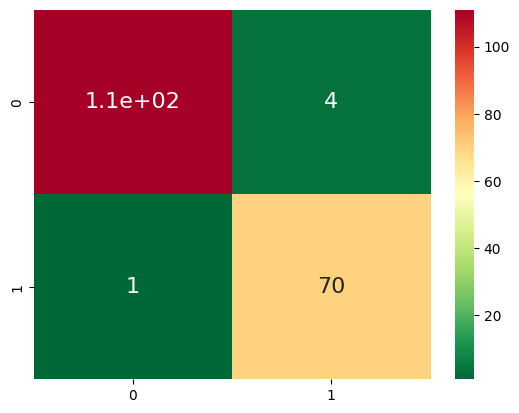

In [29]:
create_classification_report(y_test, y_pred)